### 长度奖励

In [2]:
import math

import matplotlib.pyplot as plt

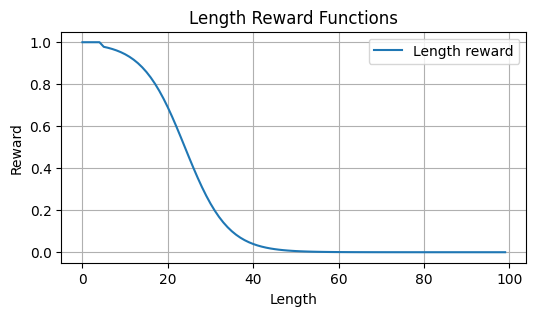

In [3]:

def length_reward_sigmoid(length, threshold=4, steepness=0.2, min_reward=0):
    """S型递减的长度奖励"""
    mid_offset = 20
    if length <= threshold:
        return 1.0
    return max(min_reward, 1 / (1 + math.exp(steepness * (length - threshold - mid_offset))))


def plot_rewards():
    lengths = list(range(0, 100))
    rewards_sigmoid = [length_reward_sigmoid(x) for x in lengths]

    plt.figure(figsize=(6, 3))
    plt.plot(lengths, rewards_sigmoid, label='Length reward')
    plt.xlabel('Length')
    plt.ylabel('Reward')
    plt.title('Length Reward Functions')
    plt.grid(True)
    plt.legend()
    plt.savefig('./fig/length_reward_functions.pdf', format='pdf', bbox_inches='tight')
    plt.show()


test_lengths = [5, 10, 20, 30, 50, 100]
# 绘制图表
plot_rewards()


### token 长度统计

In [3]:
import json
import numpy as np

In [4]:
from transformers import AutoTokenizer

model_name = "D:\model\Qwen\Qwen2___5-0___5B-Instruct"
# model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
with open('../results/res_0.json', 'r') as f:
    step0 = json.load(f)
with open('../results/res_mt02_1.json', 'r') as f:
    step1 = json.load(f)
with open('../results/res_mt02_2.json', 'r') as f:
    step2 = json.load(f)
with open('../results/res_mt02_3.json', 'r') as f:
    step3 = json.load(f)
with open('../results/res_mt02_4.json', 'r') as f:
    step4 = json.load(f)
with open('../results/res_mt02_5.json', 'r') as f:
    step5 = json.load(f)

In [6]:
step0_token_length = [len(tokenizer.encode(x)) // 100 for x in step0]
step1_token_length = [len(tokenizer.encode(x)) // 100 for x in step1]
step2_token_length = [len(tokenizer.encode(x)) // 100 for x in step2]
step3_token_length = [len(tokenizer.encode(x)) // 100 for x in step3]
step4_token_length = [len(tokenizer.encode(x)) // 100 for x in step4]
step5_token_length = [len(tokenizer.encode(x)) // 100 for x in step5]
max_token_length = max(
    step0_token_length + step1_token_length + step2_token_length + step3_token_length + step4_token_length + step5_token_length)

In [7]:
lengths = [[0] * (max_token_length + 1) for i in range(6)]

for i, x in enumerate(step0_token_length):
    lengths[0][x] += 1
for i, x in enumerate(step1_token_length):
    lengths[1][x] += 1
for i, x in enumerate(step2_token_length):
    lengths[2][x] += 1
for i, x in enumerate(step3_token_length):
    lengths[3][x] += 1
for i, x in enumerate(step4_token_length):
    lengths[4][x] += 1
for i, x in enumerate(step5_token_length):
    lengths[5][x] += 1
lengths = np.array(lengths)

In [8]:
lengths

array([[ 0,  0, 23,  8,  3,  1,  4,  5,  4,  3,  1, 48],
       [ 0,  0, 22, 14, 12,  6,  7,  1,  6,  4,  1, 27],
       [ 0,  0, 19, 17,  9,  7,  6,  6,  5,  2,  0, 29],
       [ 0,  0, 21, 21, 10,  7,  6,  5,  7,  0,  2, 21],
       [ 0,  0, 19, 24, 10,  2, 11,  6,  1,  2,  1, 24],
       [ 0,  0, 12, 20, 10,  7,  7,  3,  3,  4,  2, 32]])

In [9]:
def plot_grouped_bars(data, labels=None, bias=2, x_label=""):
    n_groups = data.shape[0]
    if labels is None:
        labels = [f'Step {i * 10}' for i in range(n_groups)]

    width = 1 / (n_groups + 1)
    x = np.arange(bias, bias + data.shape[1])

    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(n_groups):
        ax.bar(x + width * (i + 1), data[i], width, label=labels[i])
    ax.set_ylabel('number of instance')
    ax.set_xlabel(x_label)
    ax.set_xticks(x)
    ax.legend()
    plt.tight_layout()

    return fig

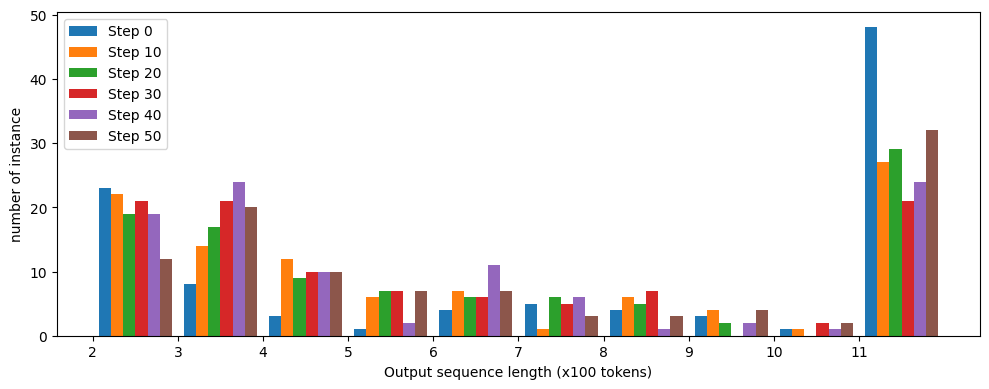

In [16]:
fig = plot_grouped_bars(lengths[:, 2:], x_label='Output sequence length (x100 tokens)',bias=2)
plt.savefig('./fig/token_length_distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [11]:
with open("../dataset/test_cases.json", "r") as f:
    test_cases = json.load(f)


def extract_numbers(expr) -> list:
    curr_num = ''
    numbers = []
    for c in expr:
        if c.isdigit():
            curr_num += c
        elif curr_num:
            numbers.append(int(curr_num))
            curr_num = ''
    if curr_num:
        numbers.append(int(curr_num))
    return numbers


def evaluate_result(results):
    correct = 0
    error = 0
    unreach = 0
    for result in results:
        lines = result.split('\n')
        last_line = lines[-1]
        if "expression:" not in last_line:
            unreach += 1
            continue
        expression = last_line.split('expression:')[-1]
        nums = extract_numbers(expression)
        if not test_cases[i].sort() == nums.sort():
            # 数字不匹配
            error += 1
            continue

        try:
            value = eval(expression)
            if abs(value - 24) < 1e-6:
                correct += 1
            else:
                # 计算结果不对
                error += 1
        except Exception as e:
            error += 1
    return correct / len(results), error / len(results), unreach / len(results)


In [12]:
metric0 = evaluate_result(step0)
metric1 = evaluate_result(step1)
metric2 = evaluate_result(step2)
metric3 = evaluate_result(step3)
metric4 = evaluate_result(step4)
metric5 = evaluate_result(step5)

In [13]:
data = np.array([
    metric0,
    metric1,
    metric2,
    metric3,
    metric4,
    metric5,
]).T * 100
data

array([[52., 73., 69., 77., 76., 65.],
       [ 2.,  1.,  3.,  2.,  1.,  4.],
       [46., 26., 28., 21., 23., 31.]])

In [14]:
def plot_multi_lines(data, labels=None, x=None):
    if x is None:
        x = [f'Step {i * 10}' for i in range(data.shape[1])]
    if labels is None:
        labels = ['Accuracy', 'Incorrect', 'Unfinished']
    # x = np.arange(data.shape[1])
    plt.figure(figsize=(10, 4))
    for i in range(data.shape[0]):
        plt.plot(x, data[i],
                 label=labels[i],
                 linewidth=2,
                 markersize=8)
    plt.ylabel('Proportion (%)')
    # plt.xticks(labels)

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    # plt.tight_layout()
    return plt.gcf()

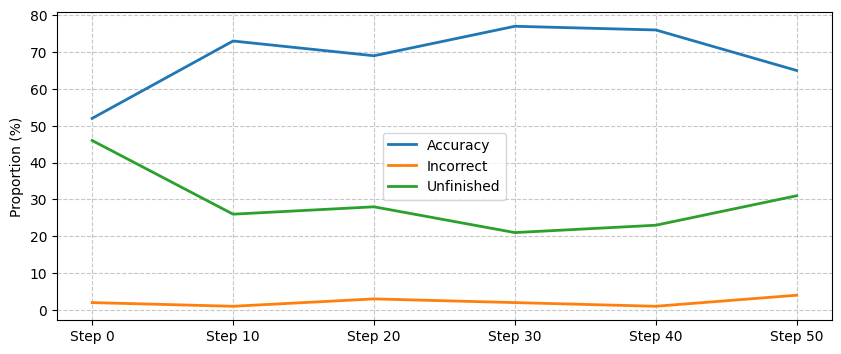

In [17]:
fig = plot_multi_lines(data)
plt.savefig('./fig/rl_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()